In [2]:
#!pip install tensorflow==1.14.0

In [3]:
#!pip install keras==2.2.5

In [4]:
import os
os.environ["PYTHONHASHSEED"] = "13"
os.environ["CUDA_VISIBLE_DEVICES"] = "0:1"

import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(13)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(13)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(13)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [5]:
import gc
import warnings

#import lightgbm as lgb
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from tqdm.notebook import tqdm

import keras
from keras.models import Sequential
from keras.layers import BatchNormalization, Dense, Dropout

path_data = "../input/ashrae-energy-prediction/"
path_train = path_data + "train.csv"
path_test = path_data + "test.csv"
path_building = path_data + "building_metadata.csv"
path_weather_train = path_data + "weather_train.csv"
path_weather_test = path_data + "weather_test.csv"

myfavouritenumber = 13
seed = myfavouritenumber

warnings.filterwarnings("ignore")

In [6]:
site_id = 11

In [7]:
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

building = pd.read_csv(path_building)

weather_train = pd.read_csv(path_weather_train)
weather_test = pd.read_csv(path_weather_test)

weather_train.drop(["sea_level_pressure", "wind_direction", "wind_speed"], axis=1, inplace=True)
weather_test.drop(["sea_level_pressure", "wind_direction", "wind_speed"], axis=1, inplace=True)

weather_train = weather_train.groupby("site_id").apply(lambda group: group.interpolate(limit_direction="both"))
weather_test = weather_test.groupby("site_id").apply(lambda group: group.interpolate(limit_direction="both"))

df_train = df_train.merge(building, on="building_id")
df_test = df_test.merge(building, on="building_id")

df_train = df_train[df_train.site_id == site_id]
df_test = df_test[df_test.site_id == site_id]

df_train["log_meter_reading"] = np.log1p(df_train.meter_reading)

df_train = df_train[~(df_train.log_meter_reading < 3)]

df_train = df_train[df_train.meter == 0]

df_train = df_train.merge(weather_train, on=["site_id", "timestamp"], how="left")
df_test = df_test.merge(weather_test, on=["site_id", "timestamp"], how="left")

df_train.timestamp = pd.to_datetime(df_train.timestamp, format='%Y-%m-%d %H:%M:%S')
df_test.timestamp = pd.to_datetime(df_test.timestamp, format='%Y-%m-%d %H:%M:%S')

df_train.building_id = df_train.building_id.astype("str")
df_test.building_id = df_test.building_id.astype("str")

del building
gc.collect()

49

In [8]:
df_train["hour"] = df_train.timestamp.dt.hour.astype("str")
df_test["hour"] = df_test.timestamp.dt.hour.astype("str")

df_train["weekday"] = df_train.timestamp.dt.weekday.astype("str")
df_test["weekday"] = df_test.timestamp.dt.weekday.astype("str")

df_train["month"] = df_train.timestamp.dt.month.astype("str")
df_test["month"] = df_test.timestamp.dt.month.astype("str")

In [9]:
features = [
    "building_id",
    "square_feet",
    "year_built",
    "floor_count",
    "primary_use",
    "air_temperature",
    "cloud_coverage",
    "dew_temperature",
    "precip_depth_1_hr",
    "hour",
    "weekday",
    "month"
]

In [10]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [11]:
cv = 4
folds = KFold(n_splits = cv, shuffle = False, random_state = seed)

df_cv = []
df_preds = []

Building Model for site_id 11 and meter 0
Preparing Site: 11 , meter: 0 , Fold: 1



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 32548 samples, validate on 10850 samples
Epoch 1/41




 - 23s - loss: 5.3307 - val_loss: 5.1447
Epoch 2/41
 - 0s - loss: 5.2283 - val_loss: 5.1191
Epoch 3/41
 - 0s - loss: 5.1297 - val_loss: 5.0604
Epoch 4/41
 - 0s - loss: 5.0333 - val_loss: 4.9611
Epoch 5/41
 - 0s - loss: 4.9099 - val_loss: 4.8532
Epoch 6/41
 - 0s - loss: 4.7713 - val_loss: 4.7072
Epoch 7/41
 - 0s - loss: 4.6092 - val_loss: 4.5292
Epoch 8/41
 - 0s - loss: 4.4216 - val_loss: 4.3387
Epoch 9/41
 - 0s - loss: 4.2147 - val_loss: 4.1215
Epoch 10/41
 - 0s - loss: 3.9754 - val_loss: 3.8775
Epoch 11/41
 - 0s - loss: 3.7367 - val_loss: 3.6157
Epoch 12/41
 - 0s - loss: 3.4583 - val_loss: 3.3123
Epoch 13/41
 - 0s - loss: 3.1805 

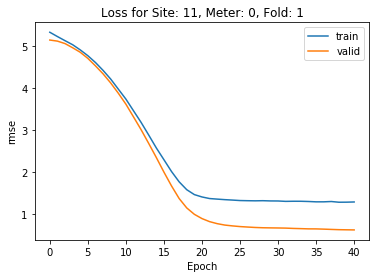

CPU times: user 2.29 s, sys: 129 ms, total: 2.42 s
Wall time: 1.83 s
Preparing Site: 11 , meter: 0 , Fold: 2
Train on 32548 samples, validate on 10850 samples
Epoch 1/41
 - 1s - loss: 5.6316 - val_loss: 4.9604
Epoch 2/41
 - 0s - loss: 5.4437 - val_loss: 4.8153
Epoch 3/41
 - 0s - loss: 5.3019 - val_loss: 4.6771
Epoch 4/41
 - 0s - loss: 5.1647 - val_loss: 4.4885
Epoch 5/41
 - 0s - loss: 5.0170 - val_loss: 4.3174
Epoch 6/41
 - 0s - loss: 4.8425 - val_loss: 4.1355
Epoch 7/41
 - 0s - loss: 4.6608 - val_loss: 3.9371
Epoch 8/41
 - 0s - loss: 4.4550 - val_loss: 3.7140
Epoch 9/41
 - 0s - loss: 4.2330 - val_loss: 3.4424
Epoch 10/41
 - 0s - loss: 3.9779 - val_loss: 3.1700
Epoch 11/41
 - 0s - loss: 3.7147 - val_loss: 2.8667
Epoch 12/41
 - 0s - loss: 3.4410 - val_loss: 2.5550
Epoch 13/41
 - 0s - loss: 3.1410 - val_loss: 2.2271
Epoch 14/41
 - 0s - loss: 2.8529 - val_loss: 1.8954
Epoch 15/41
 - 0s - loss: 2.5514 - val_loss: 1.5471
Epoch 16/41
 - 0s - loss: 2.2490 - val_loss: 1.2137
Epoch 17/41
 - 0s 

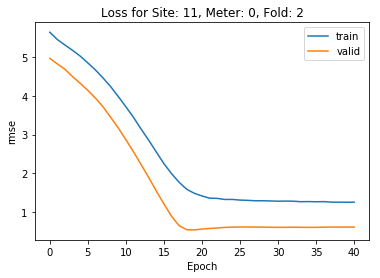

CPU times: user 2.34 s, sys: 134 ms, total: 2.48 s
Wall time: 1.89 s
Preparing Site: 11 , meter: 0 , Fold: 3
Train on 32549 samples, validate on 10849 samples
Epoch 1/41
 - 1s - loss: 5.3780 - val_loss: 5.6772
Epoch 2/41
 - 0s - loss: 5.1437 - val_loss: 5.5604
Epoch 3/41
 - 0s - loss: 4.9781 - val_loss: 5.3967
Epoch 4/41
 - 0s - loss: 4.8323 - val_loss: 5.2551
Epoch 5/41
 - 0s - loss: 4.6915 - val_loss: 5.1118
Epoch 6/41
 - 0s - loss: 4.5448 - val_loss: 4.9668
Epoch 7/41
 - 0s - loss: 4.3646 - val_loss: 4.7963
Epoch 8/41
 - 0s - loss: 4.1752 - val_loss: 4.5927
Epoch 9/41
 - 0s - loss: 3.9615 - val_loss: 4.3442
Epoch 10/41
 - 0s - loss: 3.7509 - val_loss: 4.0838
Epoch 11/41
 - 0s - loss: 3.4894 - val_loss: 3.8190
Epoch 12/41
 - 0s - loss: 3.2402 - val_loss: 3.5474
Epoch 13/41
 - 0s - loss: 2.9706 - val_loss: 3.2480
Epoch 14/41
 - 0s - loss: 2.6910 - val_loss: 2.9295
Epoch 15/41
 - 0s - loss: 2.4062 - val_loss: 2.6109
Epoch 16/41
 - 0s - loss: 2.1334 - val_loss: 2.2911
Epoch 17/41
 - 0s 

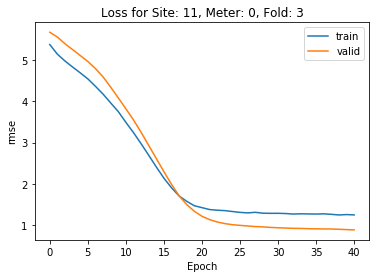

CPU times: user 2.84 s, sys: 131 ms, total: 2.97 s
Wall time: 2.36 s
Preparing Site: 11 , meter: 0 , Fold: 4
Train on 32549 samples, validate on 10849 samples
Epoch 1/41
 - 2s - loss: 5.3749 - val_loss: 5.2328
Epoch 2/41
 - 0s - loss: 5.2415 - val_loss: 5.1304
Epoch 3/41
 - 0s - loss: 5.1264 - val_loss: 5.0053
Epoch 4/41
 - 0s - loss: 5.0217 - val_loss: 4.8663
Epoch 5/41
 - 0s - loss: 4.8863 - val_loss: 4.7260
Epoch 6/41
 - 0s - loss: 4.7434 - val_loss: 4.5700
Epoch 7/41
 - 0s - loss: 4.5700 - val_loss: 4.3777
Epoch 8/41
 - 0s - loss: 4.3790 - val_loss: 4.1689
Epoch 9/41
 - 0s - loss: 4.1647 - val_loss: 3.9589
Epoch 10/41
 - 0s - loss: 3.9185 - val_loss: 3.7058
Epoch 11/41
 - 0s - loss: 3.6557 - val_loss: 3.4371
Epoch 12/41
 - 0s - loss: 3.3799 - val_loss: 3.1368
Epoch 13/41
 - 0s - loss: 3.0817 - val_loss: 2.8193
Epoch 14/41
 - 0s - loss: 2.7843 - val_loss: 2.4991
Epoch 15/41
 - 0s - loss: 2.4824 - val_loss: 2.1656
Epoch 16/41
 - 0s - loss: 2.1949 - val_loss: 1.8317
Epoch 17/41
 - 0s 

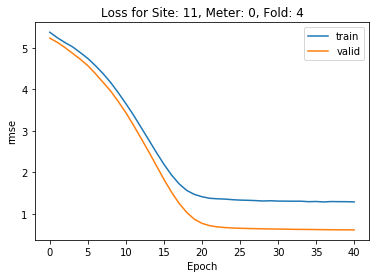

CPU times: user 2.48 s, sys: 172 ms, total: 2.65 s
Wall time: 2.06 s

CV RMSE for Site: 11 and Meter: 0 is 0.7121089457729848

CV RMSE for Site: 11 is 0.7121089457729848


In [12]:
for meter in df_train.meter.unique():
    print("Building Model for site_id", site_id, "and meter", meter)
        
    df_train_site_meter = df_train[df_train.meter == meter].reset_index(drop=True)
    df_test_site_meter = df_test[df_test.meter == meter].reset_index(drop=True)
    
    pred_val = np.zeros(df_train_site_meter.shape[0])
    pred_test = np.zeros(df_test_site_meter.shape[0])

    row_ids_test = df_test_site_meter.row_id
    y_train_site_meter = df_train_site_meter.log_meter_reading.values
    
    df_train_site_meter = df_train_site_meter[features]
    df_test_site_meter = df_test_site_meter[features]

    df_train_site_meter = pd.get_dummies(df_train_site_meter)
    df_test_site_meter = pd.get_dummies(df_test_site_meter)
        
    for k, (train_idx, valid_idx) in enumerate(folds.split(df_train_site_meter, y_train_site_meter)):
        print("Preparing Site:", site_id, ", meter:", meter, ", Fold:", k+1)
        
        X_train, y_train = df_train_site_meter.iloc[train_idx], y_train_site_meter[train_idx]
        X_valid, y_valid = df_train_site_meter.iloc[valid_idx], y_train_site_meter[valid_idx]
        
        X_train.dropna(axis=1, how="all", inplace=True)
        X_train = X_train.loc[:, (X_train != X_train.iloc[0]).any()]

        X_valid = X_valid[X_train.columns]
        X_test = df_test_site_meter[X_train.columns]
        
        df_means = pd.concat([X_train, X_valid, X_test], ignore_index=True).mean()
        X_train.fillna(df_means, inplace=True)
        X_valid.fillna(df_means, inplace=True)
        X_test.fillna(df_means, inplace=True)
        
        sc = MinMaxScaler()
        sc.fit(pd.concat([X_train, X_valid, X_test], ignore_index=True))
        
        X_train = np.array(sc.transform(X_train))
        X_valid = np.array(sc.transform(X_valid))
        X_test = np.array(sc.transform(X_test))
        
        model = Sequential()
        model.add(Dense(32, input_dim=X_train.shape[1], activation="relu", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(8, activation="tanh", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(4, activation="tanh", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(loss=rmse, optimizer="adam")
        
        model_ffnn = model.fit(X_train, y_train, epochs=41, batch_size=1000, validation_data=(X_valid, y_valid), verbose=2, shuffle=False)

        plt.plot(model_ffnn.history["loss"])
        plt.plot(model_ffnn.history["val_loss"])
        plt.title("Loss for Site: " + str(site_id) + ", Meter: " + str(meter) + ", Fold: " + str(k+1))
        plt.ylabel("rmse")
        plt.xlabel("Epoch")
        plt.legend(["train", "valid"], loc="upper right")
        plt.show()
        
        pred_val[valid_idx] = model.predict(X_valid).ravel()
        %time pred_test += model.predict(X_test).ravel() / cv
        
        gc.collect()
        
    df_valid = pd.DataFrame({"site_id": site_id, "meter": meter, "meter_reading": np.expm1(y_train_site_meter), "pred_ffnn": np.clip(np.expm1(pred_val), 0, a_max=None)})
    df_pred = pd.DataFrame({"row_id": row_ids_test, "meter_reading": np.clip(np.expm1(pred_test), 0, a_max=None)})
    
    df_cv.append(df_valid)
    df_preds.append(df_pred)
    
    gc.collect()
    
    print("\nCV RMSE for Site:", site_id, "and Meter:", meter, "is", np.sqrt(mean_squared_error(np.log1p(df_valid.meter_reading), np.log1p(df_valid.pred_ffnn))))

df_cv = pd.concat(df_cv)
print("\nCV RMSE for Site:", site_id, "is", np.sqrt(mean_squared_error(np.log1p(df_cv.meter_reading), np.log1p(df_cv.pred_ffnn))))


In [13]:
df_preds = pd.concat(df_preds)
df_preds.to_csv("../sub/ffnn_pred_site_" + str(site_id) + ".csv", index=False)

In [15]:
exit(0)